In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

## Datasets

In [185]:
root_path = Path("/home/romet/projects/ut/wp4/dataset")
paths = [
    root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
    root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30", 
    root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
    root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
    root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
    root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
    root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
    root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",               
    root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
    root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
    root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
    root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
    root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
    root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
    root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
    root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
    root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
    root_path / "2021-06-10-12-59-59_e2e_ss4",
    root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
    root_path / "2021-06-10-13-51-34_e2e_ss12",
    root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
    root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
    root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
    root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
    root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
    root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
    root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
    root_path / "2021-06-14-11-22-05_e2e_rec_ss14"
]


dataset = NvidiaDataset(paths, camera="front_wide", transform=None)
positions_df = dataset.frames

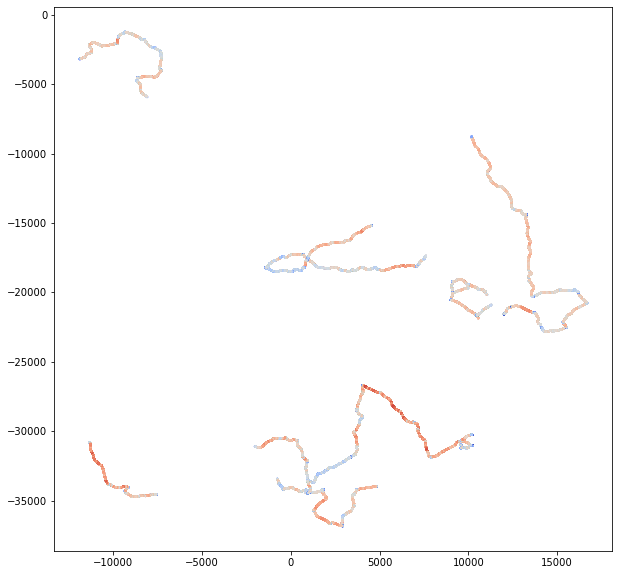

In [186]:
plt.figure(figsize=(10, 10))
plt.scatter(positions_df["position_x"], positions_df["position_y"],
            s=1,
            c=positions_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [249]:
velocity = 30
positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))
positions_df = positions_df[["position_x", "position_y", "position_x2", "position_y2", "yaw", "vehicle_speed"]]

In [250]:
positions_df[["position_x", "position_y", "yaw"]]

,position_x,position_y,yaw
index,,,
1,11299.837048,-20889.408837,-2.435013
2,11299.011255,-20890.127823,-2.431617
3,11298.190688,-20890.845215,-2.428099
4,11297.359741,-20891.574968,-2.424829
5,11296.530407,-20892.304810,-2.420576
...,...,...,...
25888,4359.018758,-15265.119754,0.344028
25889,4359.486114,-15264.947624,0.342777
25890,4359.983977,-15264.764928,0.341489


In [251]:
positions_df.to_parquet('positions.parquet', compression='GZIP')

In [252]:
from sklearn.neighbors import BallTree

positions_df = pd.read_parquet('positions.parquet')
tree = BallTree(positions_df[["position_x", "position_y", "position_x2", "position_y2"]]) 
#tree = BallTree(positions_df[["position_x", "position_y", "yaw"]]) 

In [253]:
positions_df

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed
index,,,,,,
1,11299.837048,-20889.408837,11277.019443,-20908.885923,-2.435013,10.908820
2,11299.011255,-20890.127823,11276.259919,-20909.682278,-2.431617,11.087475
3,11298.190688,-20890.845215,11275.508288,-20910.479590,-2.428099,10.969975
4,11297.359741,-20891.574968,11274.741676,-20911.283421,-2.424829,10.947773
5,11296.530407,-20892.304810,11273.996362,-20912.109274,-2.420576,11.021313
...,...,...,...,...,...,...
25888,4359.018758,-15265.119754,4387.260873,-15255.001308,0.344028,15.285135
25889,4359.486114,-15264.947624,4387.740858,-15254.864498,0.342777,15.263755
25890,4359.983977,-15264.764928,4388.251693,-15254.718225,0.341489,15.219562


In [258]:
import time

def find_speed_for_position(x, y, yaw): 
    x2 = x + (velocity * np.cos(yaw))
    y2 = y + (velocity * np.sin(yaw))
    
    closest = tree.query([[x, y, x2, y2]])
    #closest = tree.query([[x, y, yaw*100]])
    distance = closest[0][0][0]
    index = closest[1][0][0]
    #print(f"distance: {distance:0.5}, index: {index}")
    return positions_df.iloc[index], distance

In [259]:
speed, distance = find_speed_for_position(11287, -20900, -2.35)
speed

position_x       11287.582131
position_y      -20900.788192
position_x2      11266.484488
position_y2     -20922.116329
yaw                 -2.350762
vehicle_speed       11.362501
Name: 16, dtype: float64

In [264]:
x, y, yaw = 11287, -20900, -2.35
x2 = x + (velocity * np.cos(yaw))
y2 = y + (velocity * np.sin(yaw))

closest = tree.query([[x, y, x2, y2]])
#closest = tree.query([[x, y, yaw*100]])
distance = closest[0][0][0]
index = closest[1][0][0]
print(f"distance: {distance:0.5}, index: {index}")
positions_df.iloc[closest[1][0]]
#return positions_df.iloc[index], distance

distance: 1.3699, index: 15


,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed
index,,,,,,
16,11287.582131,-20900.788192,11266.484488,-20922.116329,-2.350762,11.362501


Error mean: 0.15231423546529405, max: 10.128522214541112


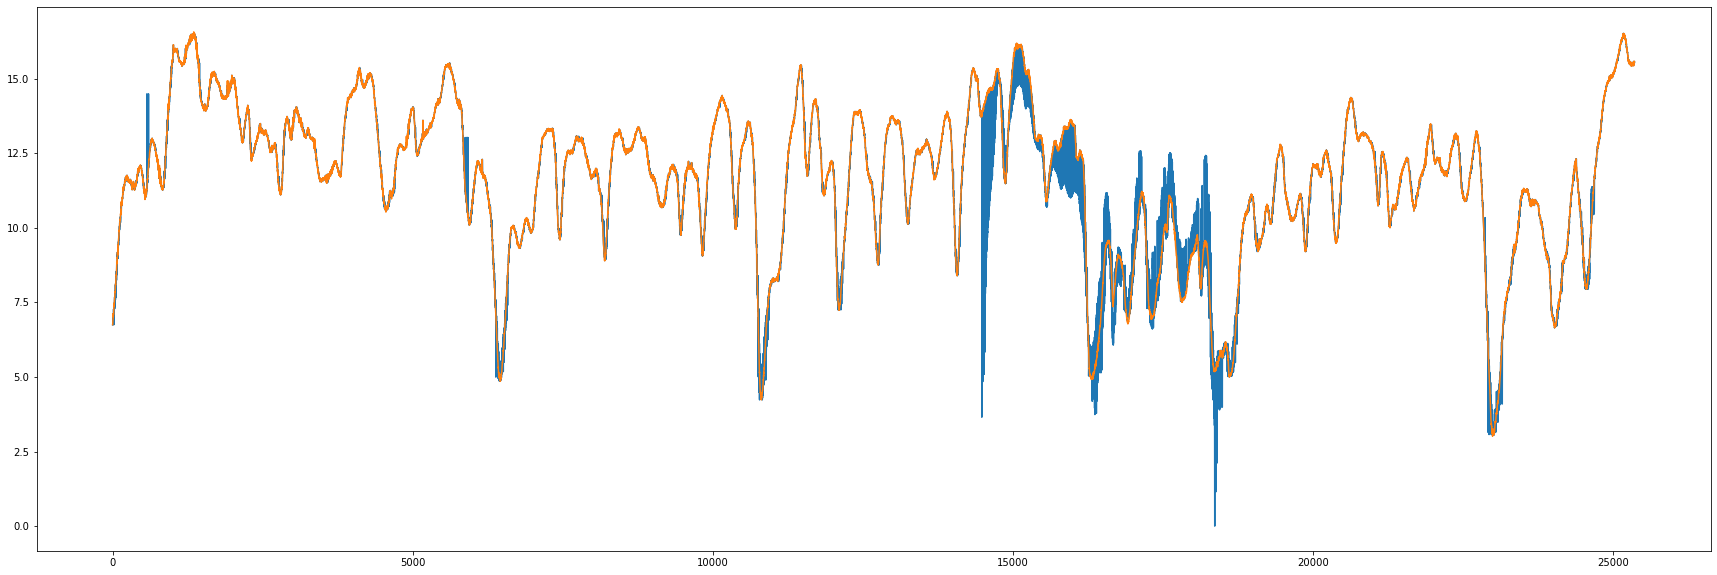

In [256]:
#     root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
#     root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30", 
#     root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
#     root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
#     root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
#     root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
#     root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
#     root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",               
#     root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
#     root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
#     root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
#     root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
#     root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
#     root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
#     root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
#     root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
#     root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
#     root_path / "2021-06-10-12-59-59_e2e_ss4",
#     root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
#     root_path / "2021-06-10-13-51-34_e2e_ss12",
#     root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
#     root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
#     root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
#     root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
#     root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
#     root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
#     root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
#     root_path / "2021-06-14-11-22-05_e2e_rec_ss14"

test_df = NvidiaDataset([root_path / "2021-06-10-12-59-59_e2e_ss4"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.3, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])

Error mean: 0.3168000329582184, max: 10.441413724051122


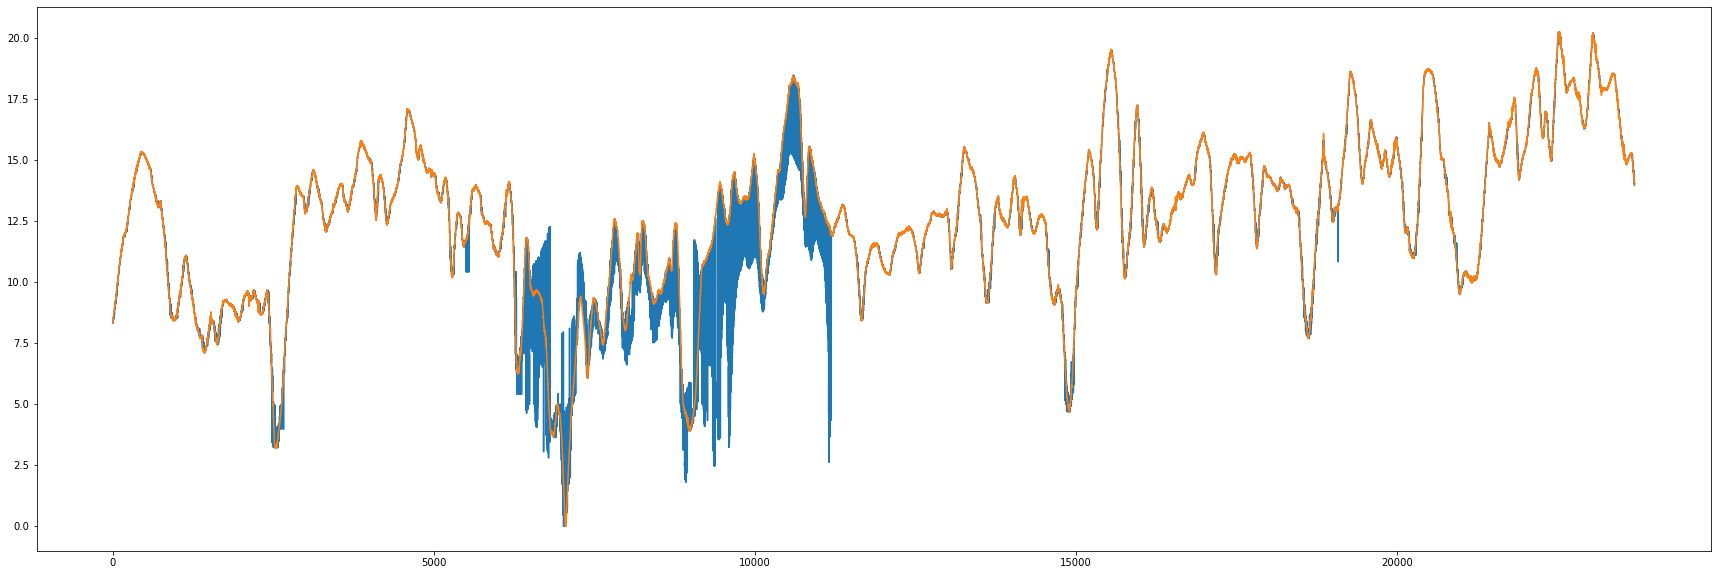

In [257]:
test_df = NvidiaDataset([root_path / "2021-06-10-13-19-22_e2e_ss4_backwards"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.3, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])